# **Waste Material Segregation for Improving Waste Management**

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [13]:
# !pip install numpy \
#             pandas==2.2.2 \
#             seaborn==0.13.2 \
#             matplotlib==3.10.0 \
#             pillow==11.1.0 \
#             tensorflow==2.18.0 \
#             keras==3.8.0 \
#             scikit-learn==1.6.1

In [14]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [15]:
# Import essential libraries
# Import essential libraries
from skimage import io
import os
import glob
import random
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import keras
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("matplotlib:", matplotlib.__version__)
print("PIL (Pillow):", Image.__version__)
print("tensorflow:", tf.__version__)
print("keras:", keras.__version__)
print("sklearn:", sklearn.__version__)

numpy: 1.26.4
pandas: 2.2.2
seaborn: 0.13.2
matplotlib: 3.10.0
PIL (Pillow): 11.1.0
tensorflow: 2.18.0
keras: 3.8.0
sklearn: 1.6.1


Load the dataset.

In [17]:
# Loading the zip file and extracting the data
zip_path = ".\\data.zip"
extract_path = ".\\"

# Load and unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [18]:
# Checking the subfolders of data file
print(os.listdir(".\\data"))

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


In [19]:
DATASET_PATH = '.\\data'
dataset_class = [file.name for file in os.scandir(DATASET_PATH) if file.is_dir()]
print(dataset_class)
waste_path = os.path.join(DATASET_PATH, dataset_class[1], '*')
print(waste_path)

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
.\data\Food_Waste\*


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [24]:
# Creating a function to load the raw images, resizing, and normalization
def load_raw_images(root_folder, image_size=(224, 224)):
    X = []
    y = []
    original_widths = []
    original_heights = []
    # List of subfolder names
    class_names = sorted(next(os.walk(root_folder))[1])
    class_to_indx = {cls: indx for indx, cls in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(root_folder, class_name)
        image_paths = glob.glob(os.path.join(class_path, '*.*'))

        for img_path in image_paths:
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    original_widths.append(w)
                    original_heights.append(h)
                    img = img.resize(image_size)
                    # Now resizing and normalizing the image to [0, 1]
                    img_array = np.array(img) / 255.0
                    X.append(img_array)
                    y.append(class_to_indx[class_name])
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    min_original_size = (min(original_widths), min(original_heights))
    max_original_size = (max(original_widths), max(original_heights))

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32), class_names, min_original_size, max_original_size



In [25]:

def verify_image_label_mapping(X, y, class_names, num_images=25):
    grid_size = int(num_images ** 0.5)
    if grid_size * grid_size != num_images:
        raise ValueError(
            f"num_images is not perfect square"
        )

    indices = np.random.choice(len(X), size=num_images, replace=False)

    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    plt.suptitle("Sample Images for Verification of Image & Label Mapping", fontsize=14, y=1.02)

    for i, idx in enumerate(indices):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = X[idx]
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.xlabel(class_names[y[idx]], fontsize=9)

    plt.tight_layout()
    plt.show()

In [26]:

# method to visualize the data distribution
def plot_class_distribution(y, class_names, title='Class Distribution in Waste Dataset'):
    unique_classes, counts = np.unique(y, return_counts=True)
    df = pd.DataFrame({'class': unique_classes, 'count': counts})
    
    # Creating bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df, x='class', y='count', hue='class', palette="viridis", legend=False)

    for i, count in enumerate(counts):
        ax.text(i, count + max(counts)*0.02, f'{count}',
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=12)
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('')
    plt.ylabel('Number of Samples', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.ylim(0, max(counts) * 1.15)
    
    plt.tight_layout()
    plt.show()


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [29]:
# Get the images and their labels
X, y, class_names, small_dim, large_dim = load_raw_images(DATASET_PATH, image_size=(224, 224))
print(X.shape)


(7625, 224, 224, 3)


In [30]:
print(X.shape)
print(class_names)
print(f"Smallest Dimension: {small_dim}")
print(f"Largest Dimension: {large_dim}")

(7625, 224, 224, 3)
['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Smallest Dimension: (256, 256)
Largest Dimension: (256, 256)


Perform any operations, if needed, on the images and labels to get them into the desired format.

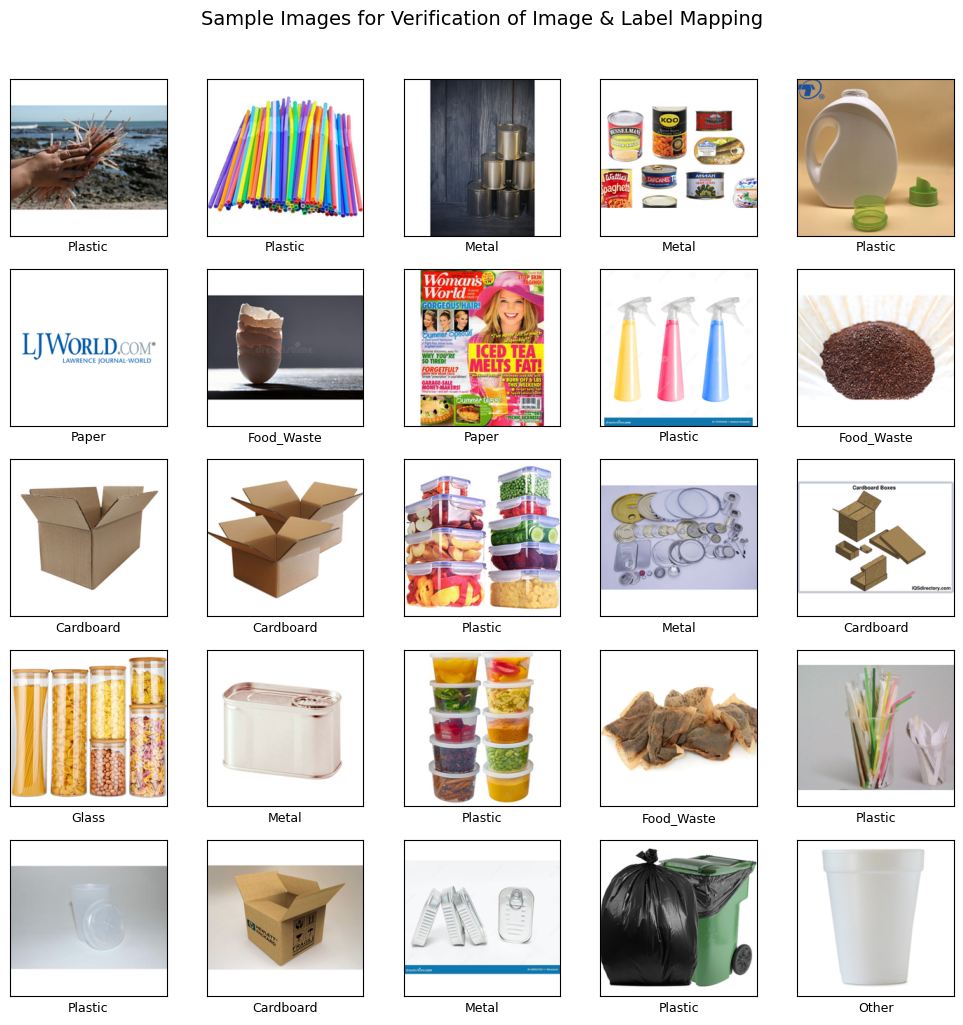

In [32]:
# verifying the label and images loaded correctly by checking 25 images from the X
verify_image_label_mapping(X, y, class_names)

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

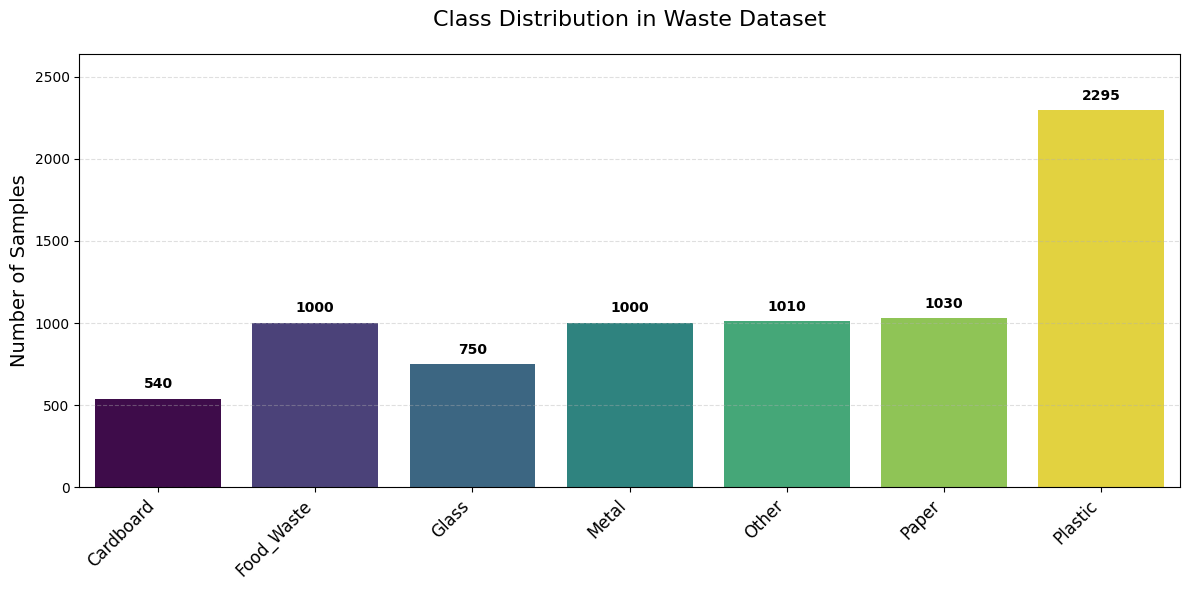

In [35]:
# Visualising the Data Distribution with help of bar plot
plot_class_distribution(y, class_names)


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

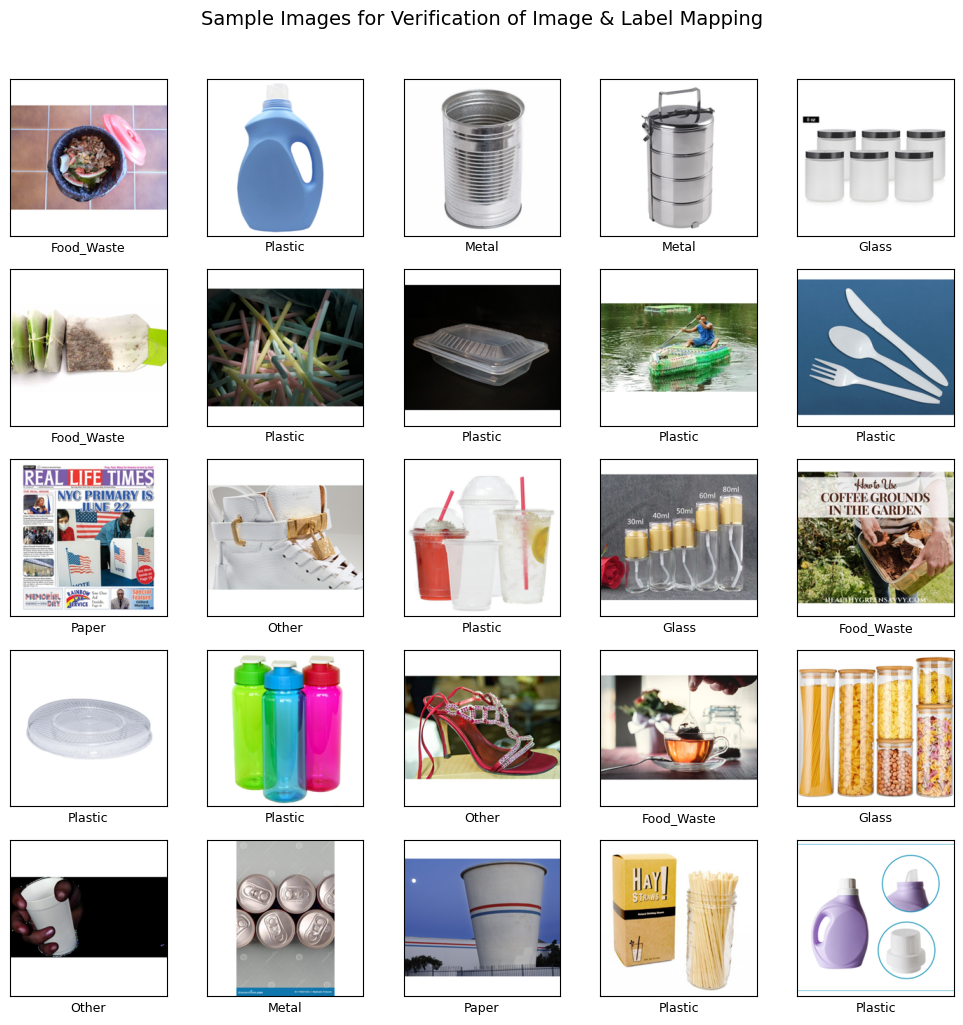

In [37]:
# Visualising the sample images with different labels
verify_image_label_mapping(X, y, class_names)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [39]:
# Find the smallest and largest image dimensions from the data set
print(f"Smallest Dimension: {small_dim}")
print(f"Largest Dimension: {large_dim}")


Smallest Dimension: (256, 256)
Largest Dimension: (256, 256)


In [40]:
# Resizing of the image already done in the while loading the raw data
print(f"Image Dimention after resizing: {X.shape}")


Image Dimention after resizing: (7625, 224, 224, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [44]:
# Encoding the labels suitably by using One Hot Coding
y = np.array(y).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)


# Printing 10 encoded labels to check the encodeded vals
print(y_encoded[535:545])
print("Label order:", encoder.categories_)
print(class_names)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Label order: [array([0, 1, 2, 3, 4, 5, 6])]
['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [47]:
# Assigning specified parts of the dataset to train and validation sets
# Step 1: Spliting into X_temp, X_temp, X_test and y_test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=0.15,
    random_state=100,
    shuffle=True
)

# Step 2: Spliting X_temp into training and validatition sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.20,
    random_state=100,
    shuffle=True
)

# checking the size of the X_train, X_val, and X__test
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_val)} samples")
print(f"Validation set: {len(X_test)} samples")


Training set: 5184 samples
Test set: 1297 samples
Validation set: 1144 samples


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [128]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import RMSprop

# Building the model
input_shape = (224, 224, 3)          

model = Sequential([
    Input(shape=input_shape),

    # Layer - 1
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Layer - 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Layer -3
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Dense head 
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(class_names), activation='softmax')  # output layer
])

# Compiling the model
model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,595,783 (21.35 MB)

 Trainable params: 5,595,463 (21.34 MB)

 Non-trainable params: 320 (1.25 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [132]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [134]:
# Training the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 84s 506ms/step - accuracy: 0.2803 - loss: 2.4049 - val_accuracy: 0.1326 - val_loss: 5.0448
Epoch 2/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 511ms/step - accuracy: 0.4219 - loss: 1.6216 - val_accuracy: 0.3069 - val_loss: 4.0978
Epoch 3/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 511ms/step - accuracy: 0.4800 - loss: 1.4512 - val_accuracy: 0.3693 - val_loss: 2.7009
Epoch 4/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 512ms/step - accuracy: 0.5335 - loss: 1.2705 - val_accuracy: 0.4827 - val_loss: 2.1483
Epoch 5/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 510ms/step - accuracy: 0.5835 - loss: 1.1522 - val_accuracy: 0.5428 - val_loss: 1.9148
Epoch 6/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 511ms/step - accuracy: 0.6397 - loss: 0.9996 - val_accuracy: 0.5012 - val_loss: 2.5877
Epoch 7/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 511ms/step - accuracy: 0.6799 - loss: 0.8882 - val_accuracy: 0.5066 - val_loss: 3.0405
Epoch 8/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 509ms/step - accuracy: 0.7212 - loss: 0

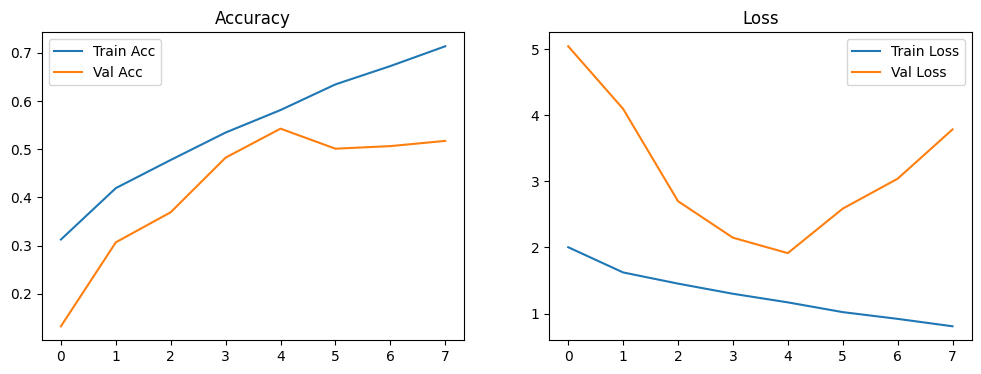

In [136]:
# ploting the history
plot_history(history)

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [140]:
# Evaluating on the test set and displaying the suitable metrics
# Evaluate Accuracy & Loss
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {val_accuracy:.4f}")
print(f"Test Loss: {val_loss:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5163 - loss: 1.8908
Test Accuracy: 0.5297
Test Loss: 1.9016


In [148]:
# Prediction on Test Data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


In [152]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Cardboard       0.54      0.74      0.62        86
  Food_Waste       0.54      0.57      0.56       142
       Glass       0.40      0.37      0.39       107
       Metal       0.42      0.40      0.41       162
       Other       0.66      0.27      0.38       156
       Paper       0.85      0.33      0.47       137
     Plastic       0.53      0.76      0.63       354

    accuracy                           0.53      1144
   macro avg       0.56      0.49      0.49      1144
weighted avg       0.56      0.53      0.51      1144



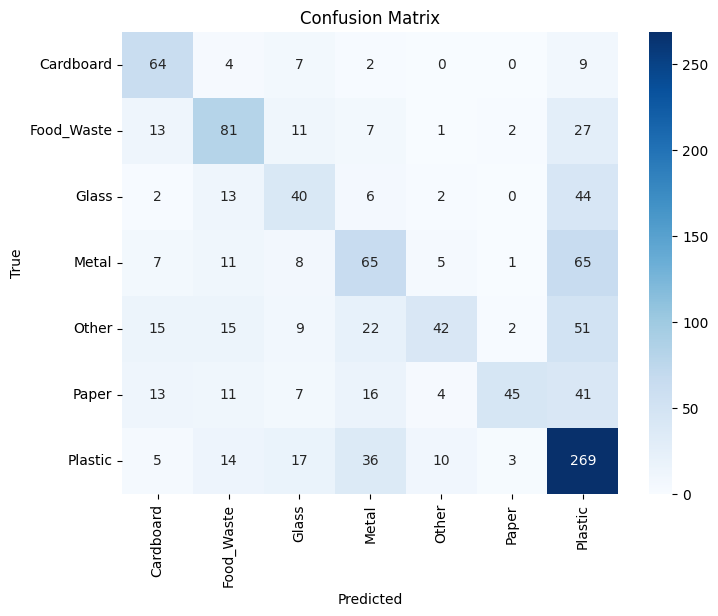

In [154]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [156]:
# Accuracy Per Class
correct = (y_pred == y_true)
for i, label in enumerate(labels):
    class_indices = (y_true == i)
    acc = np.mean(correct[class_indices])
    print(f"{label}: {acc:.2%}")

Cardboard: 74.42%
Food_Waste: 57.04%
Glass: 37.38%
Metal: 40.12%
Other: 26.92%
Paper: 32.85%
Plastic: 75.99%


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [68]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [71]:
# Create a function to augment the images




In [72]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [74]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

#### Finding About the Data

1. Data set is having 7 classes ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
2. There is class imbalance:
    1. Plastic is having most number of samples
    2. Cardboard is having least number of sample
    3. Other classes ranges between 750 to 1030 samples


#### Model training results

1. Validation loss starts increasing after epoch 5 and due to which overfitting begun

###### Accuracy & Loss Curves

> Training accuracy steadily increasing

> Validation Accuracy palteaued around 52%

> Validation Loss began rising after epoch 4


###### Classification Report Summary
> Plastic is the best recognized class due to data abundance

> Poor recall in Other, Paper, and Glass

###### Confusion Matrix Insights
By seeing the Confusion matrics, we can conlude that there many misclassification between:

> Paper <---> Plastic

> Metal, Other, and Plastic

> Glass <---> Plastic